Импорт необходимых библиотек

In [29]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

Импортируем данные с kaggle

In [30]:
train = pd.read_csv('data/train_oil.csv')
test  = pd.read_csv('data/oil_test.csv')

Исследуем данные

     Field name           Reservoir unit       Country               Region  \
0       ZHIRNOV              MELEKESKIAN        RUSSIA  FORMER SOVIET UNION   
1   LAGOA PARDA  LAGOA PARDA (URUCUTUCA)        BRAZIL        LATIN AMERICA   
2        ABQAIQ                   ARAB D  SAUDI ARABIA          MIDDLE EAST   
3     MURCHISON                    BRENT    UK /NORWAY               EUROPE   
4  WEST PEMBINA   NISKU (PEMBINA L POOL)        CANADA        NORTH AMERICA   

           Basin name        Tectonic regime  Latitude  Longitude  \
0          VOLGA-URAL  COMPRESSION/EVAPORITE   51.0000    44.8042   
1      ESPIRITO SANTO              EXTENSION  -19.6017   -39.8332   
2            THE GULF  COMPRESSION/EVAPORITE   26.0800    49.8100   
3  NORTH SEA NORTHERN              EXTENSION   61.3833     1.7500   
4      WESTERN CANADA            COMPRESSION   53.2287  -115.8008   

   Operator company Onshore/Offshore Hydrocarbon type      Reservoir status  \
0  NIZHNEVOLZHSKNET          ON

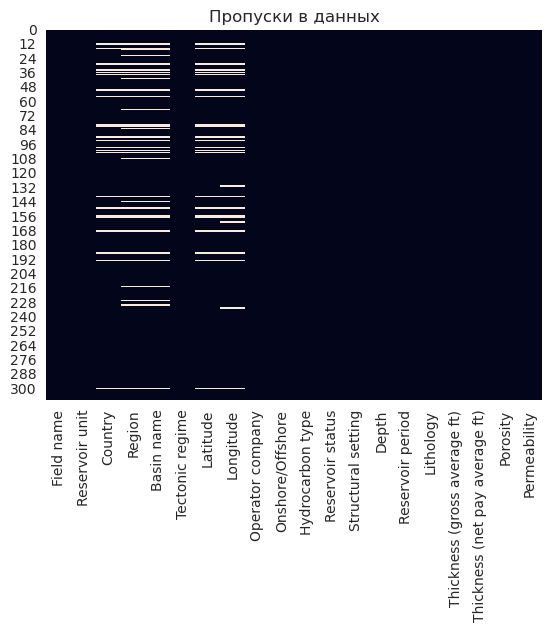

In [31]:
print(train.head())
print(train.info())
print(train.describe())
sns.heatmap(train.isna(), cbar=False)
plt.title('Пропуски в данных')
plt.show()

Выведем распределение целевой метки

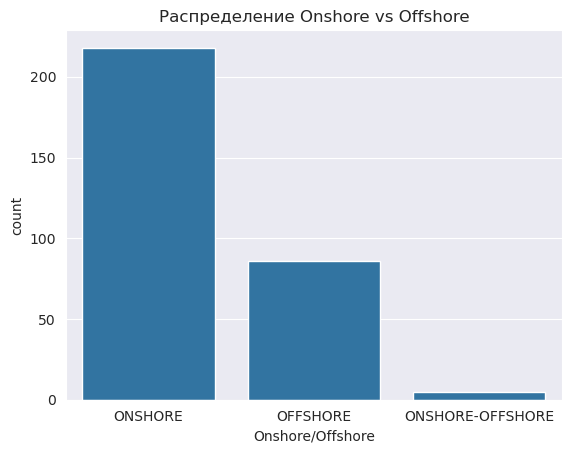

Onshore/Offshore
ONSHORE             0.705502
OFFSHORE            0.278317
ONSHORE-OFFSHORE    0.016181
Name: proportion, dtype: float64


In [32]:
sns.countplot(x='Onshore/Offshore', data=train)
plt.title('Распределение Onshore vs Offshore')
plt.show()
print(train['Onshore/Offshore'].value_counts(normalize=True))

А также корреляцию числовых признаков

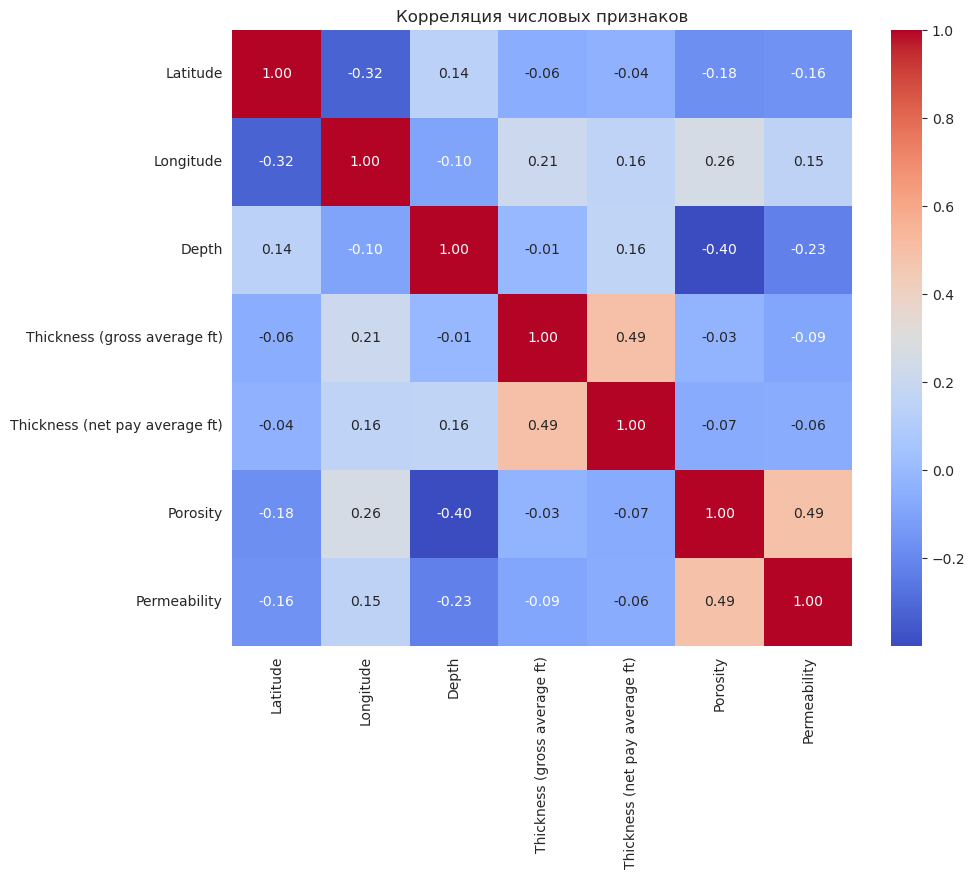

In [33]:
num_cols = train.select_dtypes(include=['int64','float64']).columns
plt.figure(figsize=(10,8))
sns.heatmap(train[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляция числовых признаков')
plt.show()

Видим, что есть пропущенные значения и сильный дисбаланс классов, а также неинформативные признаки.

Определеим целевую переменную и набор признаков

In [34]:
target_map = { 'ONSHORE': 1, 'OFFSHORE': 0, 'ONSHORE-OFFSHORE': 2 }
train['target'] = train['Onshore/Offshore'].map(target_map)

Отчистим данные, заполним пропуски, разделим признаки и целевую переменную

In [35]:
drop_cols = ['Field name', 'Reservoir unit', 'Operator company']
train.drop(columns=drop_cols, inplace=True)
test.drop(columns=drop_cols, inplace=True)
X = train.drop(columns=['Onshore/Offshore', 'target'])
y = train['target']

Определяем числовые и категориальные признаки

In [36]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
for col in num_cols:
    train[col] = pd.to_numeric(train[col], errors='coerce')
    test[col] = pd.to_numeric(test[col], errors='coerce')

Пайплайны предобработки данных

In [37]:
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=float))
])
preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

Разделяем на обучаующую и валидационную выборки

In [38]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

Трансформация и отбор признаков (SelectKBest)

In [39]:

X_train_transformed = preprocessor.fit_transform(X_train).astype(float)
X_val_transformed = preprocessor.transform(X_val).astype(float)
X_full_transformed = preprocessor.fit_transform(X).astype(float)

selector = SelectKBest(score_func=f_classif, k=50)
X_train_selected = selector.fit_transform(X_train_transformed, y_train)
X_val_selected = selector.transform(X_val_transformed)
X_full_selected = selector.fit_transform(X_full_transformed, y)

Балансировка классов

In [40]:
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=1)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)

Обучение моделей и подбор гиперпараметров

In [41]:
models = {
    "RF": RandomForestClassifier(class_weight="balanced", random_state=RANDOM_STATE),
    "GB": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "XGB": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE)
}
param_grid = {
    "RF": {"n_estimators": [50, 10000], "max_depth": [None, 10]},
    "GB": {"n_estimators": [50, 10000], "learning_rate": [0.05, 0.1]},
    "XGB": {"n_estimators": [50, 10000], "learning_rate": [0.05, 0.1]}
}

best_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    gs = GridSearchCV(
        model,
        param_grid[name],
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
        scoring="f1_macro",
        n_jobs=-1
    )
    gs.fit(X_train_balanced, y_train_balanced)
    best_models[name] = gs.best_estimator_
    preds = gs.predict(X_val_selected)
    print(f"Best params: {gs.best_params_}")
    print(classification_report(y_val, preds))
    print(confusion_matrix(y_val, preds))

Training RF...
Best params: {'max_depth': 10, 'n_estimators': 10000}
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        17
           1       0.89      0.91      0.90        44
           2       0.00      0.00      0.00         1

    accuracy                           0.85        62
   macro avg       0.55      0.56      0.55        62
weighted avg       0.84      0.85      0.85        62

[[13  4  0]
 [ 4 40  0]
 [ 0  1  0]]
Training GB...
Best params: {'learning_rate': 0.05, 'n_estimators': 10000}
              precision    recall  f1-score   support

           0       0.71      0.59      0.65        17
           1       0.83      0.91      0.87        44
           2       0.00      0.00      0.00         1

    accuracy                           0.81        62
   macro avg       0.52      0.50      0.50        62
weighted avg       0.79      0.81      0.79        62

[[10  7  0]
 [ 4 40  0]
 [ 0  1  0]]
Training XGB...


/home/vladimir/anaconda3/envs/MIFI_tasks/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:48:20] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vladimir/anaconda3/envs/MIFI_tasks/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:48:20] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vladimir/anaconda3/envs/MIFI_tasks/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:48:20] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vladimir/anaconda3/envs/MIFI_tasks/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:48:20] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Pa

Best params: {'learning_rate': 0.1, 'n_estimators': 10000}
              precision    recall  f1-score   support

           0       0.73      0.65      0.69        17
           1       0.85      0.91      0.88        44
           2       0.00      0.00      0.00         1

    accuracy                           0.82        62
   macro avg       0.53      0.52      0.52        62
weighted avg       0.81      0.82      0.81        62

[[11  6  0]
 [ 4 40  0]
 [ 0  1  0]]


 Оценка лучшей модели на отложенной валидации

In [42]:
scores = {name: f1_score(y_val, model.predict(X_val_selected), average='macro') for name, model in best_models.items()}
best_model_name = max(scores, key=scores.get)
final_model = best_models[best_model_name]
print(f"Выбрана модель: {best_model_name} с F1_macro = {scores[best_model_name]:.4f}")

Выбрана модель: RF с F1_macro = 0.5545


Предсказание на тесте и сабмишн

In [43]:
X_test_transformed = preprocessor.transform(test).astype(float)
X_test_selected = selector.transform(X_test_transformed)
final_model.fit(X_full_selected, y)
test_preds = final_model.predict(X_test_selected)

submission = pd.DataFrame({
    "index": range(len(test_preds)),
    "Onshore/Offshore": test_preds.astype(int)
})
submission.to_csv("submission.csv", index=False)
      

Скриншот с Kaggle

![img.png](img.png)